# Import libraries and data

In [3]:
from __future__ import division
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV,cross_validate,train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error,median_absolute_error,mean_squared_log_error,explained_variance_score,r2_score

#borough,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,commercial,residencial,mixed,# of bus_stop,# of subway_station,# of FELONY,# of VIOLATION,# of MISDEMEANOR,total # of poi,poi type 1,poi type 2,poi type 3,poi type 4,poi type 5,poi type 6,poi type 7,poi type 8,poi type 9,poi type 10,poi type 11,poi type 12,poi type 13,# of roads,total width of raods

#df = pd.read_csv("dataset/onehot.csv",names=['borough1','borough2','borough3','borough4','borough5','land_area','gross_area','year','price','com','res','mix','numBuses','numSubways','numFelonies','numViolations','numMisdemeanors','totalPoi','poi1','poi2','poi3','poi4','poi5','poi6','poi7','poi8','poi9','poi10','poi11','poi12','poi13','numRoads','roadWidth'],skiprows=1,index_col=False) 
#X = df.loc[:, df.columns != 'price']
#y = df['price']
#train_x, test_x, train_y, test_y = train_test_split(df.loc[:, df.columns != 'price'],df['price'],test_size=.25)
X = pickle.load(open('dataset/PCA_x.pkl'))
y = pickle.load(open('dataset/PCA_y.pkl'))
train_x, test_x, train_y, test_y = train_test_split(X,y,test_size=.25)

# Fit in correct format

In [4]:
def modelfit(alg, X, y, cv_folds=5, early_stopping_rounds=50, metric='mae'):
    
	xgb_param = alg.get_xgb_params()
	xgtrain = xgb.DMatrix(X, label=y)
	cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
		metrics=metric, early_stopping_rounds=40)
	alg.set_params(n_estimators=cvresult.shape[0])
    
	#Fit the algorithm on the data
	alg.fit(X, y)
	print(len(cvresult))

# Set params

In [5]:
xgb1 = XGBRegressor(
 learning_rate = 0.1,          #between .02 and .2, default .3
 n_estimators=1000,
 max_depth=9,                  #default 6, overfit stuff
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective='reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=0)

# Predict on training set

In [6]:
%%time
#train model
modelfit(xgb1, train_x, train_y)

#Predict training set:
yhat = xgb1.predict(test_x)

#Print model report:
print("MAE: {}".format(mean_absolute_error(test_y,yhat)))
print("MSE: {}".format(mean_squared_error(test_y,yhat)))
print("median error: {}".format(median_absolute_error(test_y,yhat)))
#print("mslog error: {}".format(mean_squared_log_error(y,yhat)))
print("variance score: {}".format(explained_variance_score(test_y,yhat)))
print("r^2 score: {}".format(r2_score(test_y,yhat)))

1000
MAE: 46942.9787133
MSE: 26196992546.9
median error: 26623.6875
variance score: 0.999266751003
r^2 score: 0.999266592977
CPU times: user 29min 35s, sys: 21.5 s, total: 29min 56s
Wall time: 10min 13s


In [8]:
# Get numerical feature importances
importances = pd.Series(xgb1.get_booster().get_fscore())
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(list(X.columns), importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda X: X[1], reverse = True)
# Print out the feature and importances
#print(feature_importances)
["{}: {}".format(*pair) for pair in feature_importances]

['0: 15725.0',
 '1: 9911.0',
 '11: 7460.0',
 '12: 5370.0',
 '13: 4978.0',
 '16: 4878.0',
 '4: 4740.0',
 '14: 4589.0',
 '15: 4414.0',
 '3: 4266.0',
 '7: 4209.0',
 '2: 4198.0',
 '17: 3945.0',
 '5: 3822.0',
 '18: 3758.0',
 '6: 3736.0',
 '10: 3564.0',
 '8: 3479.0',
 '9: 3449.0']

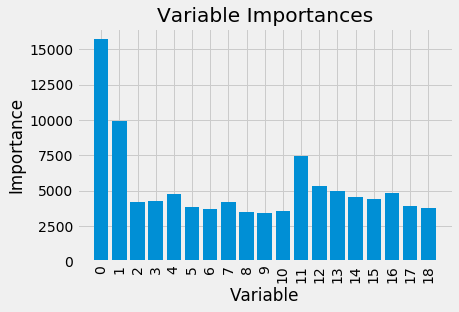

In [9]:
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, list(X.columns), rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

# SICK TUNING

In [ ]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=810, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,nthread=4,
 objective= 'reg:linear', scale_pos_weight=1, seed=0), 
 param_grid = param_test1, iid=False, cv=5)
gsearch1.fit(X,y)
#gsearch1.grid_scores_, 
gsearch1.best_params_, gsearch1.best_score_